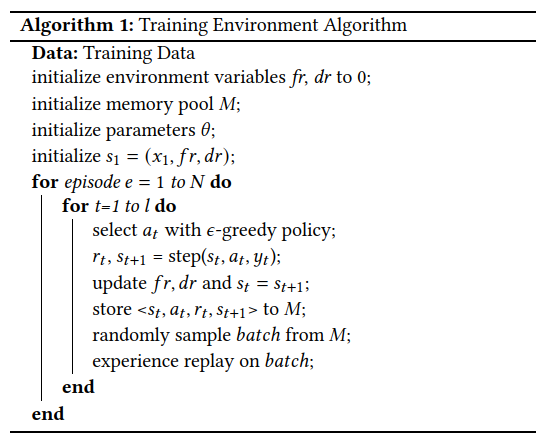

In [1]:
import gym
import gym_fraud

In [13]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import os
os.chdir('../')

In [5]:
from gym import error, spaces, utils
from gym.utils import seeding
import pandas as pd
import random


class FraudEnv(gym.Env):
    def __init__(self):
        self.f = 'dataset/creditcard.csv'
        self.df_xy = pd.DataFrame(pd.read_csv(self.f))
        self.ACTION_LOOKUP = {0: 'not_fraud', 1: 'fraud'}

        self.action_space = spaces.Discrete(len(self.ACTION_LOOKUP))
        self.observation_space = spaces.Discrete(self.df_xy.shape[0])

        self.ob = self._get_random_initial_state()
        self.episode_over = False
        self.turns = 0
        self.sum_rewards = 0.0
        self.action = 0.0
        self.current_state_index = 0
        

    def step(self, predicted_action_index):
        """
                Parameters
                ----------
                action_index :
                Returns
                -------
                ob, reward, episode_over, info : tuple
                    ob (object) :
                        an environment-specific object representing your observation of
                        the environment.
                    reward (float) :
                        amount of reward achieved by the previous action. The scale
                        varies between environments, but the goal is always to increase
                        your total reward.
                    episode_over (bool) :
                        whether it's time to reset the environment again. Most (but not
                        all) tasks are divided up into well-defined episodes, and done
                        being True indicates the episode has terminated. (For example,
                        perhaps the pole tipped too far, or you lost your last life.)
                    info (dict) :
                         diagnostic information useful for debugging. It can sometimes
                         be useful for learning (for exam   ple, it might contain the raw
                         probabilities behind the environment's last state change).
                         However, official evaluations of your agent are not allowed to
                         use this for learning.
                """

        self.turns += 1
        self.predicted_action = self._take_action(predicted_action_index)
        self.reward = self._get_reward(predicted_action_index)
        self.ob = self._get_next_state()
        if self.turns > 500 or self.sum_rewards > 0:
            self.episode_over = True

        return self.ob, self.reward, self.episode_over, {}

    def reset(self):
        """
               Reset the environment and supply a new state for initial state
               :return:
               """

        self.turns = 0
        self.ob = self._get_random_initial_state()
        self.episode_over = False
        self.sum_rewards = 0.0
        return self.ob

    def render(self, mode='human', close=False):
        pass

    def _take_action(self, action_index):
        """
                Take an action correpsonding to action_index in the current state
                :param action_index:
                :return:
                """
        assert action_index < len(self.ACTION_LOOKUP)
        self.action = action_index
        return self.action
            def take_action(self, action):
        if isinstance(action, int):
            _, reward, self.done, _ = self.env.step(action) #.item pulls value out of tensor
        else:
            _, reward, self.done, _ = self.env.step(action.item()) #.item pulls value out of tensor
        return torch.tensor([reward], device=self.device) #wrapped in a tensor for pytorch

    def _get_random_initial_state(self):
        
        nrand = random.randint(0, self.df_xy.shape[0]-64)
        assert nrand <  self.df_xy.shape[0]
        self.current_state_index = nrand
        return self.df_xy.iloc[nrand][0:30]

    def _get_reward(self, predicted_action):
        """
                Get reward for the action taken in the current state
                :return:
                """
        df = self.df_xy
        labelled_action = df.iloc[self.current_state_index]['Class']
        reward = 0.0
        if labelled_action == 0.0:
            if predicted_action == 0.0:
                reward = 0.001
            else:
                reward = -0.001
        elif labelled_action == 1.0:
            if predicted_action == 1.0:
                reward = 1.0
            else:
                reward = -1.0
        self.sum_rewards += reward
        return reward

    def _get_next_state(self):
        """
        Get the next state from current state
        :return:
        """
        df = self.df_xy
        new_state_index = self.current_state_index + 1
        next_state = df.iloc[new_state_index][0:30]
        self.current_state_index = new_state_index
        return next_state

    def _seed(self):
        return


In [6]:
env = FraudEnv()

In [7]:
env.reset().shape

(30,)

In [8]:

actions = []
rewards = []
count = 5
obs = env.reset()
print(obs)
while True:
  action = env.action_space.sample()
  reward = env.step(action)
  actions.append(action)
  rewards.append(reward)
  count -= 1
  if count==0:
    break

Time      52322.000000
V1            1.186044
V2            0.185265
V3            0.106104
V4            1.085587
V5            0.329644
V6            0.401886
V7            0.069674
V8            0.014206
V9            0.157741
V10          -0.130416
V11          -1.147540
V12           0.602716
V13           1.000121
V14          -0.090949
V15           0.413317
V16          -0.146935
V17          -0.354708
V18          -0.686984
V19          -0.110523
V20          -0.039051
V21          -0.223429
V22          -0.504596
V23          -0.111696
V24          -0.957372
V25           0.610404
V26          -0.409395
V27           0.043860
V28           0.018531
Amount       33.310000
Name: 67002, dtype: float64


In [9]:
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils

In [10]:
df = pd.read_csv('dataset/creditcard.csv')
df.head(1) # give us a sneek preview of the dataset xD

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0


In [11]:
X = df.iloc[:, :-1].values 
y = df.iloc[:, -1].values

sc = StandardScaler()
X = sc.fit_transform(X)

In [12]:
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(30, 16)
        self.fc2 = nn.Linear(16, 18)
        self.fc3 = nn.Linear(18, 20)
        self.fc4 = nn.Linear(20, 24)
        self.fc5 = nn.Linear(24, 2)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.25)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return x

In [14]:
BUFFER_SIZE = int(1e5)  #replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network
EPSILON = 0.8           # probability of chosing on-policy action

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

DEEP LIZARD CODE BELOW

In [15]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        # if memory is not full already
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else: 
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
        
    def can_provide_sample(self, batch):
        # check if there are enough saved states in memory to provide an adequate sample
        return len(self.memory) >= batch_size

In [16]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)

In [130]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
        
    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        
        if rate > random.random():
#             print('explore ', random.randrange(self.num_actions))
            a = torch.tensor(random.randrange(self.num_actions))
            a = torch.reshape(a, (1,))
            return a #explore
        else:
            with torch.no_grad():
#                 print('exploit ', policy_net(state).argmax(dim=1).item())
                a = torch.tensor(policy_net(state).argmax().item())
                a = torch.reshape(a, (1,))
                return a #exploit

In [131]:
def extract_tensors(experiences):
    
    batch = Experience(*zip(*experiences))
    
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    
    return (t1,t2,t3,t4)

In [199]:
#hyperparameters
batch_size = 64
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 5000

In [200]:
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, len(env.ACTION_LOOKUP), device)
memory = ReplayMemory(memory_size)

In [201]:
policy_net = DQN().double().to(device)
target_net = DQN().double().to(device)
target_net.load_state_dict(policy_net.state_dict()) #imports policy net weights
target_net.eval() #not in training mode
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

In [202]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

In [203]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('training...')
    plt.xlabel('episode')
    plt.ylabel('duration')
    plt.plot(values)
    
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print("Episode", len(values), "\n", moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)
        
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else: 
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

In [204]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod
    def get_next(target_net, next_states):
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device).double()
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

In [205]:
state = env.reset()

In [206]:
state = torch.tensor(state.values)

In [207]:
state.shape

torch.Size([30])

In [208]:
test = policy_net(state)

In [209]:
test.shape

torch.Size([2])

In [210]:
a = torch.tensor(test.argmax().item())

In [211]:
torch.reshape(a,(1,))

tensor([1])

In [212]:
action = agent.select_action(state, policy_net)

In [213]:
action

tensor([0])

In [214]:
#     def take_action(self, action):
#         if isinstance(action, int):
#             _, reward, self.done, _ = self.env.step(action) #.item pulls value out of tensor
#         else:
#             _, reward, self.done, _ = self.env.step(action.item()) #.item pulls value out of tensor
#         return torch.tensor([reward], device=self.device) #wrapped in a tensor for pytorch

In [215]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

In [216]:
torch.tensor(env.step(0)[1])

tensor(0.0010)

In [217]:
 next_state, reward, done, _ = env.step(action)

In [218]:
action = agent.select_action(state, policy_net)

In [219]:
torch.zeros(batch_size).to(QValues.device).shape

torch.Size([64])

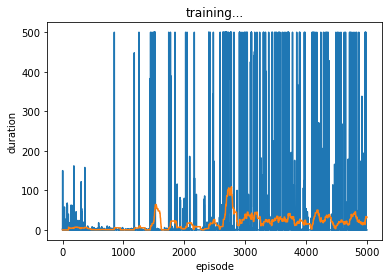

Episode 5000 
 100 episode moving avg: 31.55


In [220]:
episode_durations = []
for episode in range(num_episodes):
    state = env.reset()
    state = torch.tensor(state.values)
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
#         STOPPED HERE 20221013
#         reward = em.take_action(action)
        next_state, reward, done, _ = env.step(action)
        reward = torch.tensor(reward)
        reward = torch.reshape(reward, (1,))
        next_state = torch.tensor(next_state.values)
#         next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            states = states.reshape(batch_size, 30) #fix this 30 with a variable
            next_states = next_states.reshape(batch_size, 30)
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if env.episode_over:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break
            
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
# em.close()

In [176]:
next_states.shape

torch.Size([1920])

DEEP LIZARD CODE ABOVE

In [18]:
class ReplayBuffer():
  def __init__(self, action_size, buffer_size, batch_size, seed):
    self.action_size = action_size
    self.memory = deque(maxlen=buffer_size)
    self.batch_size = batch_size
    self.experiences = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    self.seed = random.seed(seed)
  
  def add(self, state, action, reward, next_state, done):
    experience = self.experiences(state, action, reward, next_state, done)
    self.memory.append(experience)

  def sample(self):
    experiences = random.sample(self.memory, k=self.batch_size)
#     print('experiences: ', experiences)
#     print('size 30 : ', [e for e in experiences if e.state.shape[0] == 30])
    print("len(self.memory)", len(self.memory))
    states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).double().to(device)
    actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).double().to(device)
    rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).double().to(device)
    next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).double().to(device)
    dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None])).double().to(device)
    return (states, actions, rewards, next_states, dones)

    # experiences = random.sample(self.memory, k=BATCH_SIZE)

    # batch = self.experiences(*zip(experiences))

    # states = torch.cat(batch.state)
    # actions = torch.cat(batch.actions)
    # rewards = torch.cat(batch.reward)
    # next_states = torch.cat(batch.next_state)
    # dones = torch.cat(batch.done)
    #return random.sample(self.memory, BATCH_SIZE)

    
  
  def __len__(self):
      return len(self.memory)


In [17]:
class Agent():
  def __init__(self, action_size, seed):
    self.action_size = action_size
    self.seed = random.seed(seed)


    # Q - Network
    self.qnet_local = DQN().double().to(device)
    self.qnet_target = DQN().double().to(device)
    self.optimizer = optim.Adam(self.qnet_local.parameters(), lr=0.01)

    self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

    self.t_step = 0
    self.train_loss = []

  def step(self, state, action, reward, next_state, done):
    self.memory.add(state, action, reward, next_state, done)


    # learn every 4 timesteps
    self.t_step = (self.t_step+1)%64
    if self.t_step == 0:
      experience = self.memory.sample()
#       print('Experience sampled from memory : ', experience)
      self.learn(experience, GAMMA)


  def epsilon_greedy_action(self, state):
    state = state.to(device)
    self.qnet_local.eval()
    with torch.no_grad():
      action_values = self.qnet_local(state).max(1)[1]#.view(1, 1)
    self.qnet_local.train()

    if random.random() < 0.8:
#       print('Predicted action based on QNetwork : ', action_values)
      return action_values.cpu()
    else:
      random_action = random.choices(np.arange(self.action_size), k=BATCH_SIZE)
#       print('Chosing  random actions for the batch : ', random_action)
      return torch.DoubleTensor(random_action)
  
  def learn(self, experiences, gamma):
    #print('Started learning')
    states, actions, rewards, next_states, done = experiences#experiences[0].state, experiences[0].action, experiences[0].reward, experiences[0].next_state, experiences[0].done 
    criterion = torch.nn.BCELoss()
    self.qnet_local.train()
    self.qnet_target.eval()

    #predicted_targets = self.qnet_local(states)#.gather(1, actions)

    #print(next_states.view(1, 1))
    with torch.no_grad():
      labels_next = self.qnet_target(next_states).detach().max(1)[0].unsqueeze(1)
    
    #print('labels_next {}'.format(labels_next))
    
    labels = 0 + (gamma * labels_next)
    predicted_targets = self.qnet_local(states).gather(1, actions.long())

    #print("Predicted targets : {}, labels : {}".format(predicted_targets, labels))

    loss = criterion(predicted_targets, labels).to(device)
#     print("===========================Training loss ============================")
#     print(loss.item())
    self.train_loss.append(loss.item())
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    print('recent training loss : ', self.train_loss[-1])

    # perform soft update
    self.soft_update(self.qnet_local, self.qnet_target, TAU)
  
  def soft_update(self, local_model, target_model, tau):
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
      target_param.data.copy_(tau*local_param.data + (1-tau)*target_param.data)

In [18]:
class ReplayBuffer():
  def __init__(self, action_size, buffer_size, batch_size, seed):
    self.action_size = action_size
    self.memory = deque(maxlen=buffer_size)
    self.batch_size = batch_size
    self.experiences = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    self.seed = random.seed(seed)
  
  def add(self, state, action, reward, next_state, done):
    experience = self.experiences(state, action, reward, next_state, done)
    self.memory.append(experience)

  def sample(self):
    experiences = random.sample(self.memory, k=self.batch_size)
#     print('experiences: ', experiences)
#     print('size 30 : ', [e for e in experiences if e.state.shape[0] == 30])
    print("len(self.memory)", len(self.memory))
    states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).double().to(device)
    actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).double().to(device)
    rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).double().to(device)
    next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).double().to(device)
    dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None])).double().to(device)
    return (states, actions, rewards, next_states, dones)

    # experiences = random.sample(self.memory, k=BATCH_SIZE)

    # batch = self.experiences(*zip(experiences))

    # states = torch.cat(batch.state)
    # actions = torch.cat(batch.actions)
    # rewards = torch.cat(batch.reward)
    # next_states = torch.cat(batch.next_state)
    # dones = torch.cat(batch.done)
    #return random.sample(self.memory, BATCH_SIZE)

    
  
  def __len__(self):
      return len(self.memory)


In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, random_state=1)

X_train = torch.from_numpy(X_train)
Y_train = torch.from_numpy(Y_train).double()

train = data_utils.TensorDataset(X_train, Y_train)
train_loader = data_utils.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

In [20]:
env.reset()

nrand:  229448


Time      145927.000000
V1            -2.217978
V2             1.959408
V3            -0.630127
V4            -0.974365
V5             1.155177
V6            -0.635466
V7             1.673501
V8            -1.500343
V9             1.973039
V10            1.657137
V11           -0.520161
V12           -1.068451
V13           -1.328349
V14           -2.167184
V15            0.233789
V16           -0.389703
V17            0.039867
V18            0.016546
V19            0.008212
V20           -0.335358
V21           -0.127024
V22           -0.476486
V23            0.094446
V24            0.477181
V25           -1.123183
V26           -1.133069
V27           -3.398807
V28           -0.744285
Amount         8.180000
Name: 229448, dtype: float64

In [21]:
# check reward strategy once
# add probability to epsilon_greedy
import json
deep_agent = Agent(action_size=2, seed=0)
num_episodes = 2
max_t = 500
state = 0
env.state_idx = 0

true_positive = []
true_negative = []

false_positive = []
false_negative = []

TPR = []
FPR = []

current_state = df.iloc[0, :-1].values

for i in range(num_episodes):  
  print("==========================EPOCH {} COMPLETED===================".format(i))  

  print('Current state : ', i)
  score = 0
  for state_idx, data in enumerate(train_loader, 0):
        inputs, labels = data
#         print(inputs)
#         print(data)
        print("env.sum_rewards: ", env.sum_rewards)
        action = deep_agent.epsilon_greedy_action(inputs)
        for a in action:
#             print('action taken : ', action)
            next_state, reward, done, info = env.step(a)
#             print('Next state dtype ; ', next_state.dtype)
#             print('Next state ', next_state)
            deep_agent.step(current_state, a, reward, next_state, done)
            current_state = next_state
        if state_idx > max_t:
            print("max_t exceeded: ", state_idx)
            break
#             state = next_state
#             score += reward
#             print(type(info), env.step(a))
#             roc_info = json.loads(info)

==========================EPOCH 0 COMPLETED===================
Current state :  0
env.sum_rewards:  0.0
len(self.memory) 64
recent training loss :  45.174145285967896
env.sum_rewards:  -0.014000000000000005
len(self.memory) 128
recent training loss :  41.55828763702888
env.sum_rewards:  -0.02000000000000001
len(self.memory) 192
recent training loss :  46.90830710380482
env.sum_rewards:  0.04400000000000003
len(self.memory) 256
recent training loss :  37.1824340945266
env.sum_rewards:  0.10800000000000008
len(self.memory) 320
recent training loss :  55.35202156726773
env.sum_rewards:  -1.830000000000004
len(self.memory) 384
recent training loss :  49.47737686845167
env.sum_rewards:  -1.7660000000000111
len(self.memory) 448
recent training loss :  52.516926418752725
env.sum_rewards:  -1.768000000000011
len(self.memory) 512
recent training loss :  58.818449109451834
env.sum_rewards:  -1.704000000000018
len(self.memory) 576
recent training loss :  60.92870339763064
env.sum_rewards:  -1.640

env.sum_rewards:  -2.1100000000004138
len(self.memory) 5184
recent training loss :  9.79517598006879
env.sum_rewards:  -3.0470000000004207
len(self.memory) 5248
recent training loss :  8.726945722511994
env.sum_rewards:  -4.9850000000004
len(self.memory) 5312
recent training loss :  4.0875509863658195
env.sum_rewards:  -5.922000000000379
len(self.memory) 5376
recent training loss :  4.628384255620381
env.sum_rewards:  -5.858000000000358
len(self.memory) 5440
recent training loss :  2.5295511607918373
env.sum_rewards:  -5.846000000000354
len(self.memory) 5504
recent training loss :  4.035701613370817
env.sum_rewards:  -5.782000000000332
len(self.memory) 5568
recent training loss :  5.981511194211567
env.sum_rewards:  -5.782000000000332
len(self.memory) 5632
recent training loss :  8.728707981327533
env.sum_rewards:  -5.7920000000003355
len(self.memory) 5696
recent training loss :  5.732225272964394
env.sum_rewards:  -5.728000000000314
len(self.memory) 5760
recent training loss :  5.6406

recent training loss :  7.793039078032985
env.sum_rewards:  -12.286000000000916
len(self.memory) 10496
recent training loss :  19.17629880805411
env.sum_rewards:  -12.222000000000952
len(self.memory) 10560
recent training loss :  24.180557310676296
env.sum_rewards:  -12.158000000000987
len(self.memory) 10624
recent training loss :  23.004526903623248
env.sum_rewards:  -12.094000000001023
len(self.memory) 10688
recent training loss :  15.061133020310585
env.sum_rewards:  -12.030000000001058
len(self.memory) 10752
recent training loss :  16.207560953128908
env.sum_rewards:  -11.966000000001094
len(self.memory) 10816
recent training loss :  12.128934640510035
env.sum_rewards:  -12.903000000001128
len(self.memory) 10880
recent training loss :  16.458744268200967
env.sum_rewards:  -12.839000000001164
len(self.memory) 10944
recent training loss :  24.058597403038995
env.sum_rewards:  -12.7750000000012
len(self.memory) 11008
recent training loss :  19.1853279089626
env.sum_rewards:  -12.77900

len(self.memory) 15680
recent training loss :  19.099348680117057
env.sum_rewards:  -13.782000000003412
len(self.memory) 15744
recent training loss :  33.11101717925973
env.sum_rewards:  -13.718000000003448
len(self.memory) 15808
recent training loss :  13.91959356768997
env.sum_rewards:  -13.720000000003447
len(self.memory) 15872
recent training loss :  22.647800534763988
env.sum_rewards:  -13.656000000003482
len(self.memory) 15936
recent training loss :  16.987033904104575
env.sum_rewards:  -14.64300000000349
len(self.memory) 16000
recent training loss :  23.51544878050829
env.sum_rewards:  -14.649000000003486
len(self.memory) 16064
recent training loss :  16.768726814904383
env.sum_rewards:  -14.585000000003522
len(self.memory) 16128
recent training loss :  21.163944710486867
env.sum_rewards:  -15.522000000003557
len(self.memory) 16192
recent training loss :  24.381615238390623
env.sum_rewards:  -15.458000000003592
len(self.memory) 16256
recent training loss :  21.977553696396733
en

recent training loss :  44.8570630245048
env.sum_rewards:  -21.121000000002784
len(self.memory) 20864
recent training loss :  31.76843510344096
env.sum_rewards:  -21.1330000000028
len(self.memory) 20928
recent training loss :  47.980375035166794
env.sum_rewards:  -21.06900000000272
len(self.memory) 20992
recent training loss :  35.61726216094425
env.sum_rewards:  -21.005000000002642
len(self.memory) 21056
recent training loss :  49.99426398959771
env.sum_rewards:  -21.00300000000264
len(self.memory) 21120
recent training loss :  57.73354767505181
env.sum_rewards:  -20.93900000000256
len(self.memory) 21184
recent training loss :  44.774185041270535
env.sum_rewards:  -20.875000000002483
len(self.memory) 21248
recent training loss :  51.1628021929419
env.sum_rewards:  -20.811000000002405
len(self.memory) 21312
recent training loss :  47.65923007659189
env.sum_rewards:  -20.747000000002327
len(self.memory) 21376
recent training loss :  39.543372414501974
env.sum_rewards:  -21.6840000000022

recent training loss :  71.52344518291878
env.sum_rewards:  -26.039999999997796
len(self.memory) 26048
recent training loss :  73.0538282784225
env.sum_rewards:  -25.97599999999772
len(self.memory) 26112
recent training loss :  77.19565250707463
env.sum_rewards:  -26.91299999999764
len(self.memory) 26176
recent training loss :  69.93843659866835
env.sum_rewards:  -26.916999999997646
len(self.memory) 26240
recent training loss :  76.4061478317187
env.sum_rewards:  -26.852999999997568
len(self.memory) 26304
recent training loss :  71.51749512849875
env.sum_rewards:  -26.78899999999749
len(self.memory) 26368
recent training loss :  73.33539986102977
env.sum_rewards:  -26.72499999999741
len(self.memory) 26432
recent training loss :  55.17467367922649
env.sum_rewards:  -26.660999999997333
len(self.memory) 26496
recent training loss :  70.98560315391676
env.sum_rewards:  -26.596999999997255
len(self.memory) 26560
recent training loss :  65.33119357993866
env.sum_rewards:  -26.532999999997177

len(self.memory) 31296
recent training loss :  69.17861136037233
env.sum_rewards:  -22.08999999999297
len(self.memory) 31360
recent training loss :  66.58543055771173
env.sum_rewards:  -22.02599999999289
len(self.memory) 31424
recent training loss :  72.0413244337714
env.sum_rewards:  -21.961999999992813
len(self.memory) 31488
recent training loss :  68.98724776608918
env.sum_rewards:  -21.955999999992805
len(self.memory) 31552
recent training loss :  64.96307033592595
env.sum_rewards:  -21.891999999992727
len(self.memory) 31616
recent training loss :  69.165497690302
env.sum_rewards:  -22.82899999999265
len(self.memory) 31680
recent training loss :  77.07535584827755
env.sum_rewards:  -22.764999999992572
len(self.memory) 31744
recent training loss :  61.84733985715944
env.sum_rewards:  -22.700999999992494
len(self.memory) 31808
recent training loss :  73.55791147496751
env.sum_rewards:  -22.636999999992415
len(self.memory) 31872
recent training loss :  73.73400304439457
env.sum_reward

recent training loss :  63.01308582845877
env.sum_rewards:  -25.19499999998821
len(self.memory) 36544
recent training loss :  71.42374130211084
env.sum_rewards:  -25.13099999998813
len(self.memory) 36608
recent training loss :  73.91146045689568
env.sum_rewards:  -25.066999999988052
len(self.memory) 36672
recent training loss :  70.00983448673084
env.sum_rewards:  -25.002999999987974
len(self.memory) 36736
recent training loss :  68.26789542993372
env.sum_rewards:  -24.938999999987896
len(self.memory) 36800
recent training loss :  59.22225357038417
env.sum_rewards:  -24.874999999987818
len(self.memory) 36864
recent training loss :  66.70272416372748
env.sum_rewards:  -24.81099999998774
len(self.memory) 36928
recent training loss :  63.710584414155925
env.sum_rewards:  -24.74699999998766
len(self.memory) 36992
recent training loss :  67.37908311930833
env.sum_rewards:  -24.682999999987583
len(self.memory) 37056
recent training loss :  69.40692863758215
env.sum_rewards:  -24.618999999987

len(self.memory) 41664
recent training loss :  73.96856369117408
env.sum_rewards:  -21.80999999998285
len(self.memory) 41728
recent training loss :  74.81669525470957
env.sum_rewards:  -21.74599999998277
len(self.memory) 41792
recent training loss :  69.2012642758207
env.sum_rewards:  -21.681999999982693
len(self.memory) 41856
recent training loss :  69.34479614184679
env.sum_rewards:  -21.617999999982615
len(self.memory) 41920
recent training loss :  64.76421490673428
env.sum_rewards:  -21.553999999982537
len(self.memory) 41984
recent training loss :  73.67118430361958
env.sum_rewards:  -21.48999999998246
len(self.memory) 42048
recent training loss :  75.67393834876921
env.sum_rewards:  -21.50599999998248
len(self.memory) 42112
recent training loss :  63.2431356998616
env.sum_rewards:  -21.4419999999824
len(self.memory) 42176
recent training loss :  76.80373564473263
env.sum_rewards:  -21.377999999982322
len(self.memory) 42240
recent training loss :  66.32465236308292
env.sum_rewards:

recent training loss :  69.06109584969212
env.sum_rewards:  -20.518999999977606
len(self.memory) 46976
recent training loss :  70.78818241227137
env.sum_rewards:  -20.454999999977527
len(self.memory) 47040
recent training loss :  67.35298050646213
env.sum_rewards:  -20.39099999997745
len(self.memory) 47104
recent training loss :  74.34766372350413
env.sum_rewards:  -20.32699999997737
len(self.memory) 47168
recent training loss :  75.62007636859022
env.sum_rewards:  -20.262999999977293
len(self.memory) 47232
recent training loss :  72.16048654812914
env.sum_rewards:  -20.198999999977215
len(self.memory) 47296
recent training loss :  73.66548279221693
env.sum_rewards:  -20.134999999977136
len(self.memory) 47360
recent training loss :  65.64329944549685
env.sum_rewards:  -20.070999999977058
len(self.memory) 47424
recent training loss :  77.34800976009356
env.sum_rewards:  -21.00799999997698
len(self.memory) 47488
recent training loss :  75.25136630604946
env.sum_rewards:  -20.943999999976

recent training loss :  76.7245979077424
env.sum_rewards:  -17.385999999972555
len(self.memory) 52224
recent training loss :  70.61287623743348
env.sum_rewards:  -17.391999999972562
len(self.memory) 52288
recent training loss :  73.4988026885342
env.sum_rewards:  -18.328999999972485
len(self.memory) 52352
recent training loss :  66.94834351358995
env.sum_rewards:  -18.264999999972407
len(self.memory) 52416
recent training loss :  73.69770603167484
env.sum_rewards:  -18.20099999997233
len(self.memory) 52480
recent training loss :  63.5176245466961
env.sum_rewards:  -18.13699999997225
len(self.memory) 52544
recent training loss :  73.70309993824395
env.sum_rewards:  -18.122999999972233
len(self.memory) 52608
recent training loss :  64.32272401436313
env.sum_rewards:  -18.058999999972155
len(self.memory) 52672
recent training loss :  72.16126816308287
env.sum_rewards:  -17.994999999972077
len(self.memory) 52736
recent training loss :  64.2293417855688
env.sum_rewards:  -17.930999999972
le

IndexError: single positional indexer is out-of-bounds

Text(0, 0.5, 'training loss')

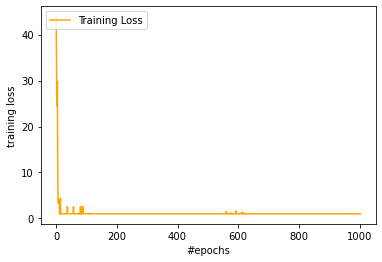

In [75]:
import numpy as np
import matplotlib.pyplot as plt

#plt.plot(x, y1, "-b", label="sine")


plt.plot(range((max_t+2)*num_episodes), deep_agent.train_loss, color='orange', label='Training Loss')
plt.legend(loc="upper left")
plt.xlabel('#epochs')
plt.ylabel('training loss')

In [78]:
X_test = torch.from_numpy(X_test)
Y_test = torch.from_numpy(Y_test).double()

TypeError: expected np.ndarray (got Tensor)

In [77]:
test = data_utils.TensorDataset(X_test, Y_test)
test_loader = data_utils.DataLoader(test, batch_size=64, shuffle=True)


In [70]:
tp = 0
tn = 0
fp = 0
fn = 0
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        predicted = deep_agent.epsilon_greedy_action(inputs)        
        total += labels.size(0)
        print(predicted.dtype)
        correct += (predicted.double()==labels).sum().item() 
        print(100*correct/total)
        for p, l in zip(predicted, labels):
            if l == 1:
                if p == 1:
                    tp +=1
                else:
                    fn +=1
            else:
                if p == 0:
                    tn +=1
                else:
                    fp +=1
        

print('Accuracy of the network on the {} inputs: {}'.format(
    X_test.shape[0], 100 * correct/total))

torch.int64
100.0
torch.int64
99.21875
torch.int64
98.95833333333333
torch.int64
99.21875
torch.int64
99.0625
torch.int64
98.69791666666667
torch.int64
98.66071428571429
torch.int64
98.046875
torch.int64
97.91666666666667
torch.int64
98.125
torch.int64
98.01136363636364
torch.float64
94.53125
torch.int64
94.83173076923077
torch.int64
95.20089285714286
torch.int64
95.52083333333333
torch.int64
95.703125
torch.int64
95.86397058823529
torch.float64
93.05555555555556
torch.int64
93.25657894736842
torch.int64
93.515625
torch.float64
91.44345238095238
torch.float64
89.98579545454545
torch.int64
90.4211956521739
torch.int64
90.625
torch.int64
91.0
torch.int64
91.34615384615384
torch.int64
91.66666666666667
torch.int64
91.85267857142857
torch.int64
92.02586206896552
torch.int64
92.23958333333333
torch.int64
92.43951612903226
torch.float64
91.064453125
torch.int64
91.28787878787878
torch.int64
91.49816176470588
torch.int64
91.65178571428571
torch.int64
91.84027777777777
torch.int64
92.060810810

torch.float64
88.94896193771626
torch.int64
88.98706896551724
torch.int64
89.02491408934708
torch.int64
89.0625
torch.int64
89.09449658703072
torch.int64
89.13159013605443
torch.int64
89.16843220338983
torch.int64
89.20502533783784
torch.int64
89.23611111111111
torch.int64
89.26698825503355
torch.int64
89.29765886287625
torch.int64
89.3125
torch.int64
89.34281561461793
torch.int64
89.37810430463576
torch.int64
89.4131600660066
torch.int64
89.44798519736842
torch.int64
89.47233606557377
torch.int64
89.48120915032679
torch.float64
89.28644136807817
torch.int64
89.31107954545455
torch.int64
89.33050161812298
torch.int64
89.35987903225806
torch.int64
89.38906752411576
torch.int64
89.41806891025641
torch.int64
89.45187699680511
torch.int64
89.48049363057325
torch.int64
89.51388888888889
torch.int64
89.54707278481013
torch.int64
89.57018927444796
torch.int64
89.59316037735849
torch.int64
89.62578369905957
torch.float64
89.4921875
torch.int64
89.52492211838006
torch.int64
89.55260093167702
to

In [71]:
print(tp, tn, fp, fn)

29 25193 3239 20
